In [ ]:
!pip install surfboard

In [ ]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive
import librosa
import librosa.display
import IPython.display as ipd
import tensorflow as tf
from tqdm import tqdm
import sklearn
import surfboard
from surfboard.sound import Waveform
from surfboard.feature_extraction import extract_features

%tensorflow_version 2.x

In [ ]:
drive.flush_and_unmount() 

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
os.chdir('/content/gdrive/MyDrive/DSCI400')

In [ ]:
from utils import DataGenerator, Modeling, SurfboardFeatures, Parameters 

In [ ]:
from utils.DataGenerator import DataGenerator, Data_Viz, Get_matrix_inputs
from utils.SurfboardFeatures import GenerateVectors, Reduce_Dim, Get_feature_vectors
from utils.Modeling import build_model2, build_model, build_cnn_train, build_train, get_accuracy

In [ ]:
# Set file/audio locations
new_audio_path = '/content/gdrive/MyDrive/DSCI400/Regroup Audio New/coughvid'
coughnet_audio_path = '/content/gdrive/MyDrive/DSCI400/Coughnet Audio'
coswara_audio_path = '/content/gdrive/MyDrive/DSCI400/Regroup Audio New/cough-coswara'

In [ ]:
audio_path = new_audio_path

# Prep for Modeling


## DataGenerator

In [ ]:
# Produces spectrogram images as well as labels for testing, training, and validation sets
x_train, y_train, x_test, y_test, x_val, y_val = Get_matrix_inputs(new_audio_path, coswara_audio_path, audio_path, load=True)

# DataGenerator Viz

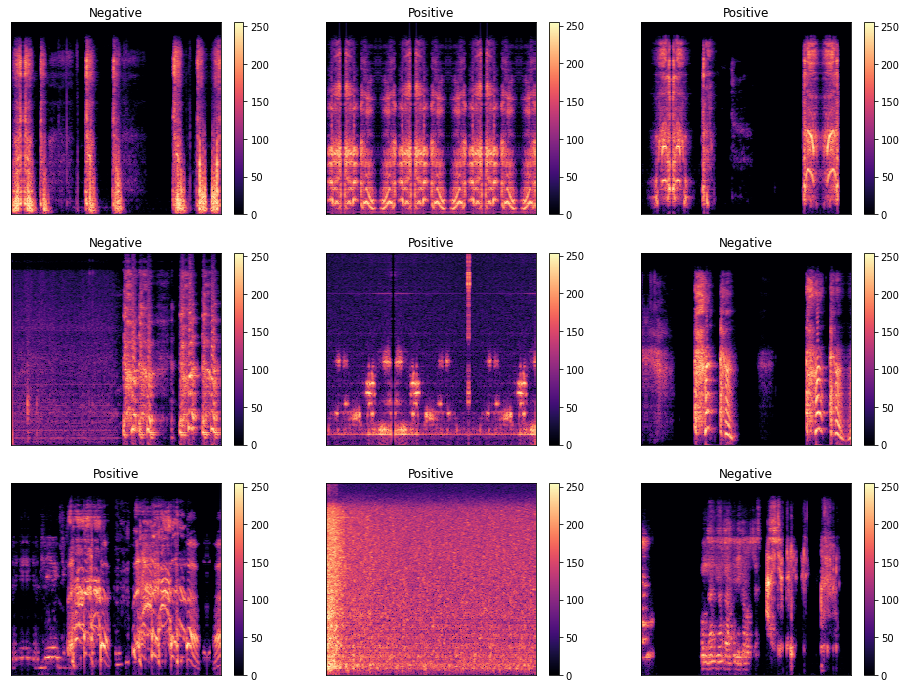

In [ ]:
# Produces image representations of a select number of spectrograms
Data_Viz(3, 3, x_test, y_test)

# GenerateVectors

In [ ]:
# Generates test, train, and validation feature vectors for the model
test_data_vec, train_data_vec, val_data_vec = Get_feature_vectors(new_audio_path, coswara_audio_path, audio_path, load=True)

# Reduce Dim of Vectors

In [ ]:
# Performs dimensionality reduction of the feature vectors
x_test2, x_train2, x_val2 = Reduce_Dim(Parameters.PCA_COMPONENTS, train_data_vec, test_data_vec, val_data_vec)

# Set Batch Size (will hopefully be fixed)

In [ ]:
if audio_path == coswara_audio_path:
  BATCH_SIZE = 167 # I dont like this but else it gives an error
  VAL_BATCH_SIZE = 211
elif audio_path == new_audio_path:
  BATCH_SIZE = 76
  VAL_BATCH_SIZE =  81 # Coughnet - 90

# Get Input Shapes

In [ ]:
input_shape_1 = x_train.shape[1:]
input_shape_1

(512, 215, 1)

In [ ]:
input_shape_2 = x_train2.shape[1:]
input_shape_2

(256,)

# CNN + Sequential

## Build and Train Model

In [ ]:
# Builds a model combining of a Convolutional Neural Network and a Multi-Layer
#   Perceptron to use MFCC data as inputs to differentiate between COVID-19
#   positive and COVID-19 negative audio clips

new_model = build_model2(input_shape_1, input_shape_2, 2, BATCH_SIZE=BATCH_SIZE)

In [ ]:
# Trains CNN + Multi-Layer Perceptron model using input data from MFCCs
model_hist = build_train(new_model,[x_train, x_train2], y_train, BATCH_SIZE, 5, True)

In [ ]:
# Checks the accuracy of the model on the test set of data
predict, MSE, RMSE, accuracy = get_accuracy(new_model, [x_test, x_test2], y_test)

## Accuracy Plots

In [ ]:
plt.plot(model_hist.history['loss'], label='Loss (training data)')
plt.title('Loss Function for CNN + MLP Model')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

plt.plot(model_hist.history['accuracy'], label='Accuracy (training data)')
plt.title('Accuracy for CNN + MLP Model')
plt.ylabel('Accuracy Value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()
plt.show()

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
ns_auc = roc_auc_score(y_test, predict)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, predict)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='ROC')
pyplot.title('ROC curve for the CNN + MLP model')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

# CNN (API)

## Build and Train Model


In [ ]:
# Builds a Convolutional Neural Network (CNN) model 
a = build_model(input_shape_1, 2, BATCH_SIZE=BATCH_SIZE)

In [ ]:
# Trains the CNN model on MFCCs
cnn_hist = build_cnn_train(a, x_train, y_train, BATCH_SIZE, 30, True, VAL_BATCH_SIZE, x_val, y_val)

In [ ]:
# Measures accuracy of the CNN model
cnn_predict, cnn_MSE, cnn_RMSE, cnn_accuracy = get_accuracy(a, x_test, y_test)

## Accuracy Plots 2

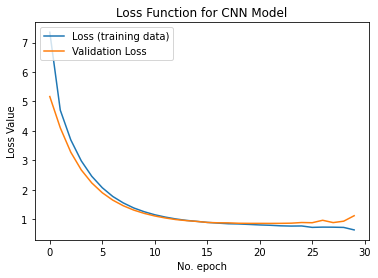

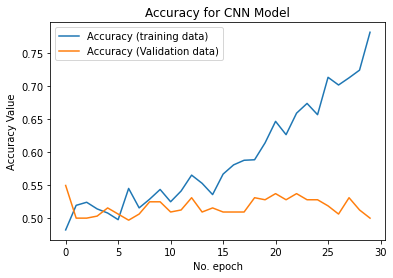

No Skill: ROC AUC=0.493


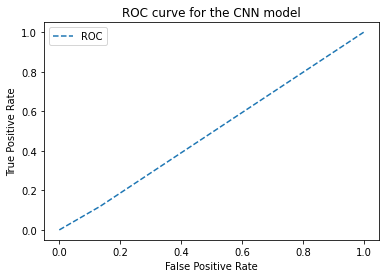

In [ ]:
plt.plot(cnn_hist.history['loss'], label='Loss (training data)')
plt.plot(cnn_hist.history['val_loss'], label='Validation Loss')
plt.title('Loss Function for CNN Model')
plt.ylabel('Loss Value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()


plt.plot(cnn_hist.history['accuracy'], label='Accuracy (training data)')
plt.plot(cnn_hist.history['val_accuracy'], label='Accuracy (Validation data)')
plt.title('Accuracy for CNN Model')
plt.ylabel('Accuracy Value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()
plt.show()

ns_auc = roc_auc_score(y_test, cnn_predict)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, cnn_predict)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='ROC')
pyplot.title('ROC curve for the CNN model')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
# New_Audio:
# Training: 1292
# Testing: 404
# Validation: 324

# CoughNet:
# Training: 720
# Testing: 90
# Validation: 90
# BATCH_SIZE = 72

# Coswara:
# Training: 1670
# Testing: 515
# Validation: 422